# Capstone 2 Modeling<a id='Modeling'></a>

## Table of Contents<a id='Table_of_Contents'></a>
* [4 Modeling](#Modeling)
    * [4.1 Imports](#Imports)
        * [4.1.1 Import Libraries](#Import_Libraries)
        * [4.1.2 Import Data](#Import_Data)
        * [4.1.3 Import Models](#Import_Models)
    
    * [4.2 Hyperparameter Tuning](#Hyperparameter_Tuning)
        * [4.2.1 Random Search](#Random_Search)
        * [4.2.2 Bayesian Optimization](#Bayesian_Optimization)
    
    * [4.3 Modeling_Scenarios](#Modeling_Scenarios)
    
    * [4.4 ](#)
            
    * [4.5 ](#)


## 4.1 Imports<a id="Imports"></a>

### 4.1.1 Import Libraries<a id="Import_Libraries"></a>

In [1]:
import json
import pickle
import pandas as pd
import xgboost as xgb
from sklearn.metrics import recall_score, plot_roc_curve

### 4.1.2 Import Data<a id="Import_Data"></a>

In [2]:
# Read in X_train and y_train
X_train = pd.read_csv("../data/processed/X_train.csv")
y_train = pd.read_csv("../data/processed/y_train.csv")

In [3]:
# Read in X_test and y_test 
X_test = pd.read_csv("../data/processed/X_test.csv")
y_test = pd.read_csv("../data/processed/y_test.csv")

### 4.1.3 Import Models<a id="Import_Models"></a>

In [4]:
# Model with hyperparameters chosen by random search
rs_filepath = "../models/rs_model.pkl"
with open(rs_filepath, "rb") as f:
    rs_model = pickle.load(f)

# Model with hyperparameters chosen by Bayesian optimization
bo_filepath = "../models/bo_model.pkl"
with open(bo_filepath, "rb") as f:
    bo_model = pickle.load(f)

## 4.2 Hyperparameter Tuning<a id="Hyperparameter Tuning"></a>

The following hyperparameters ranges were set: 

* eta (learning_rate): between 0.3 and 0.9
* max_depth: between 1 and 9
* min_child_weight: between 1 and 7
* colsample_bytree: between 0.1 and 0.8
* gamma: between 0.1 and 0.5

We searched this hyperspace using random search and Bayesian optimization. 

In [5]:
def show_params(model, param_list):
    """
    Given an xgboost model, print out the parameters listed in param list
    """
    param_dict = model.get_xgb_params()
    for param in param_list:
        print(param, " = ", param_dict[param])

In [6]:
param_list = ["eta","max_depth","min_child_weight", "colsample_bytree", "gamma"]

### 4.2.1 Random Search<a id="Random_Search"></a>

In [7]:
# Get train set performance
y_pred_train = rs_model.predict(X_train)
print("Train set performance: ", recall_score(y_train, y_pred_train))

# Get test set performance
y_pred_test = rs_model.predict(X_test)
print("Test set performance: ", recall_score(y_test, y_pred_test))

Train set performance:  0.7339924274295331
Test set performance:  0.6411411411411412


In [8]:
# Best parameters chosen by random search 
show_params(rs_model, param_list)

eta  =  0.5922466648437668
max_depth  =  9
min_child_weight  =  4
colsample_bytree  =  0.3205186652131847
gamma  =  0.1477290020150721


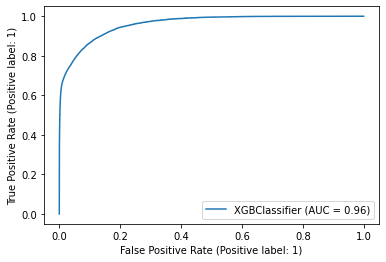

In [9]:
# ROC-AUC curve of model based on test set
plot_roc_curve(rs_model, X_test, y_test);

### 4.2.2 Bayesian Optimization<a id="Bayesian_Optimization"></a>

In [10]:
# Get train set performance
y_pred_train = bo_model.predict(X_train)
print("Train set performance: ", recall_score(y_train, y_pred_train))

# Get test set performance
y_pred_test = bo_model.predict(X_test)
print("Test set performance: ", recall_score(y_test, y_pred_test))

Train set performance:  0.6639882204459403
Test set performance:  0.6446446446446447


In [11]:
# Best parameters chosen by Bayesian optimization 
show_params(bo_model, param_list)

eta  =  0.6000000000000001
max_depth  =  5
min_child_weight  =  4
colsample_bytree  =  0.45000000000000007
gamma  =  0.30000000000000004


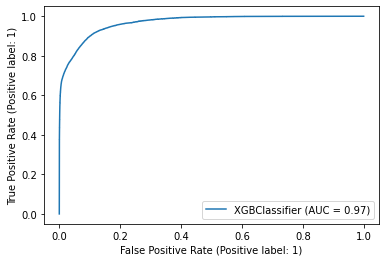

In [12]:
# ROC-AUC curve of model based on test set
plot_roc_curve(bo_model, X_test, y_test);

Bayesian optimization results in a model with slightly better metrics, so we will use "bo_model" going forward.  

## 4.3 Modeling Scenarios<a id="Modeling_Scenarios"></a>